In [3]:
import pandas as pd
import lightgbm as lgb
import warnings
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
submit_df = pd.read_csv("./submit_sample.csv", header=None)

In [5]:
train_df.shape, test_df.shape, submit_df.shape

((27100, 18), (18050, 17), (18050, 2))

In [6]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


   age            id       balance        day    duration  campaign  \
0   22   4539.000000  -4554.000000  30.000000   14.000000  1.000000   
1   24  11053.500000  42797.375000  17.750000  128.250000  1.500000   
2   25  12773.571429  45144.600000  17.742857  243.828571  1.428571   
3   26  16377.900000  40011.600000  15.800000  245.600000  1.600000   
4   27  12933.229730  50828.211712  20.247748  275.490991  1.608108   

        pdays  previous         y  
0  106.000000  2.000000  1.000000  
1  352.875000  0.000000  0.125000  
2  414.685714  0.028571  0.142857  
3  413.200000  0.200000  0.300000  
4  418.126126  0.004505  0.058559  
22       1
24       8
25      35
26      10
27     222
28      66
29    1104
30    3226
31    4464
32    2176
33    2318
34    2521
35    2888
36     907
37    1368
38      12
39     270
40     333
41     153
42     307
43     385
44      39
45     252
46     435
47     115
48     675
49     683
50      18
51     279
52       5
53     236
54       4
55   

<BarContainer object of 42 artists>

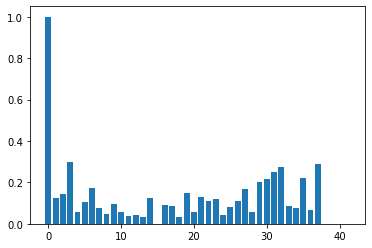

In [68]:
age_list = range(0, 120, 10)
age_ctgr = pd.cut(train_df['age'], bins=age_list)

target_df = train_df.groupby(['age'], as_index=False).mean()
print(target_df.head())
print(train_df['age'].value_counts().sort_index()) #plot


plt.bar(target_df.index, target_df['y'])

<BarContainer object of 11 artists>

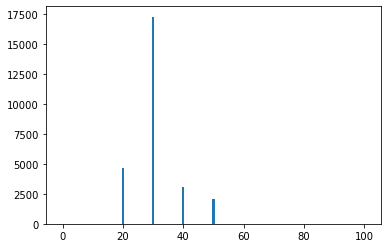

In [46]:
age_list = range(0, 120, 10)
age_ctgr = pd.cut(train_df['age'], bins=age_list)

plot_data = age_ctgr.value_counts().sort_index()
plt.bar(range(0, 110, 10), plot_data)

In [9]:
all_df = pd.concat([train_df, test_df])
del train_df, test_df
gc.collect()

81

In [11]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    lbl.transform(all_df[col])
    all_df[col] = lbl.transform(all_df[col])

In [12]:
train_df = all_df[all_df['y']!=-999]
test_df = all_df[all_df['y']==-999]

In [14]:
y_train = train_df['y']
X_train = train_df.drop(['y', 'id'], axis=1)
X_test = test_df.drop(['y', 'id'], axis=1)

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

In [17]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    "objective":"binary"
}

model = lgb.train(
    params, lgb_train,
    valid_sets = [lgb_train, lgb_eval],
    verbose_eval = 10,
    num_boost_round = 1000,
    early_stopping_rounds=10
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.209427	valid_1's binary_logloss: 0.219289
[20]	training's binary_logloss: 0.191038	valid_1's binary_logloss: 0.209227
[30]	training's binary_logloss: 0.178925	valid_1's binary_logloss: 0.204428
[40]	training's binary_logloss: 0.169569	valid_1's binary_logloss: 0.203095
[50]	training's binary_logloss: 0.161995	valid_1's binary_logloss: 0.20335
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.163581	valid_1's binary_logloss: 0.203038


In [18]:
y_pred

array([0.78074173, 0.07075874, 0.02624937, ..., 0.06533223, 0.0072316 ,
       0.13983576])

In [20]:
submit_df[1] = y_pred

In [21]:
submit_df.to_csv('./submit.csv', index=False, header=None)